In [4]:
import h5py

In [8]:
nxs_file_path = r"E:\P03_Yufeng\11020885\raw\ak_3_au_pet_dc_17p_align_00002\lmbd01\ak_3_au_pet_dc_17p_align_00002_00001.nxs"

with h5py.File(nxs_file_path, 'r') as f:
    def print_tree(name, obj):
        print(name)
    f.visititems(print_tree)

entry
entry/instrument
entry/instrument/detector
entry/instrument/detector/acquisition_mode
entry/instrument/detector/bit_depth_readout
entry/instrument/detector/calibration_date
entry/instrument/detector/collection
entry/instrument/detector/collection/beam_energy
entry/instrument/detector/collection/calib_energy
entry/instrument/detector/collection/compression_rate
entry/instrument/detector/collection/config_file_path
entry/instrument/detector/collection/distortion_correction_applied
entry/instrument/detector/collection/error_code
entry/instrument/detector/collection/frame_numbers
entry/instrument/detector/collection/latest_image_number
entry/instrument/detector/collection/module_id
entry/instrument/detector/collection/operating_mode
entry/instrument/detector/collection/save_all_images
entry/instrument/detector/collection/save_file_name
entry/instrument/detector/collection/save_file_path
entry/instrument/detector/collection/shutter_time
entry/instrument/detector/collection/thread_no
e

In [10]:
with h5py.File(nxs_file_path, "r") as f:
    data = f["/entry/instrument/detector/data"][()]
print(data.shape)

(1, 516, 1556)


In [38]:
nxs_file_path = r"E:\ExpData\Zhaonan\lmbd\lmbd\zhaonan_pvk_yscan_00001_00001_m09.nxs"
with h5py.File(nxs_file_path, "r") as f:
    data = f["/entry/instrument/detector/data"][()]
print(data.shape)

(50, 516, 1556)


In [47]:

with h5py.File(nxs_file_path, "r") as f:
    comp = f["/entry/instrument/detector/geometry/component_index"][()]
    mod  = f["/entry/instrument/detector/collection/module_id"][()]
    layout = f["/entry/instrument/detector/layout"][()]  # 如果存在
    distance = f["entry/instrument/detector/translation/distance"][()]

print("component_index:", comp)
print("module_id:", mod)
print("layout:\n", layout)
print("distance:", distance)

component_index: [0]
module_id: b'w111-I06,CRN,0x00006f96'
layout:
 b'1556X516'
distance: [0. 0. 0.]


In [20]:
# Gather all m**.nxs files in the same folder as `nxs_file_path`
from pathlib import Path
import re

base_path = Path(nxs_file_path)
folder = base_path.parent

# Match trailing m-number before .nxs, e.g., *_m01.nxs, *_m12.nxs
pattern = re.compile(r"m(\d+)\.nxs$", re.IGNORECASE)

nxs_files = []
for p in folder.glob("*.nxs"):
    m = pattern.search(p.name)
    if m:
        nxs_files.append((int(m.group(1)), p))

if not nxs_files:
    raise FileNotFoundError(f"No m**.nxs files found in {folder}")

nxs_files.sort(key=lambda x: x[0])
ordered_paths = [p for _, p in nxs_files]

print(f"Found {len(ordered_paths)} NXs files in {folder}:")
for idx, p in enumerate(ordered_paths, 1):
    print(f"{idx:2d}: {p.name}")

Found 11 NXs files in E:\ExpData\Zhaonan\lmbd\lmbd:
 1: zhaonan_pvk_yscan_00001_00001_m01.nxs
 2: zhaonan_pvk_yscan_00001_00001_m02.nxs
 3: zhaonan_pvk_yscan_00001_00001_m03.nxs
 4: zhaonan_pvk_yscan_00001_00001_m04.nxs
 5: zhaonan_pvk_yscan_00001_00001_m05.nxs
 6: zhaonan_pvk_yscan_00001_00001_m06.nxs
 7: zhaonan_pvk_yscan_00001_00001_m07.nxs
 8: zhaonan_pvk_yscan_00001_00001_m08.nxs
 9: zhaonan_pvk_yscan_00001_00001_m09.nxs
10: zhaonan_pvk_yscan_00001_00001_m10.nxs
11: zhaonan_pvk_yscan_00001_00001_m11.nxs


In [23]:
# Load the first frame from each file and validate shapes
import numpy as np
import h5py

dataset_path = '/entry/instrument/detector/data'

images = []
shape_ref = None
for p in ordered_paths:
    with h5py.File(p, 'r') as f:
        dset = f[dataset_path]
        img0 = dset[20]  # first frame (index 0)
        if shape_ref is None:
            shape_ref = img0.shape
        elif img0.shape != shape_ref:
            raise ValueError(f'Inconsistent image shapes: {p.name} has {img0.shape}, expected {shape_ref}')
        images.append(img0.astype(np.float32))

print(f'Loaded {len(images)} images of shape {shape_ref}')

Loaded 11 images of shape (516, 1556)


C:\Users\zhaiyufe\AppData\Local\Temp\ipykernel_31292\2627274307.py:33: RuntimeWarning: invalid value encountered in log1p
  im = plt.imshow(np.log1p(grid_ma), cmap=cmap, origin='upper')


C:\Users\zhaiyufe\AppData\Local\Temp\ipykernel_31292\2627274307.py:33: RuntimeWarning: invalid value encountered in log1p
  im = plt.imshow(np.log1p(grid_ma), cmap=cmap, origin='upper')


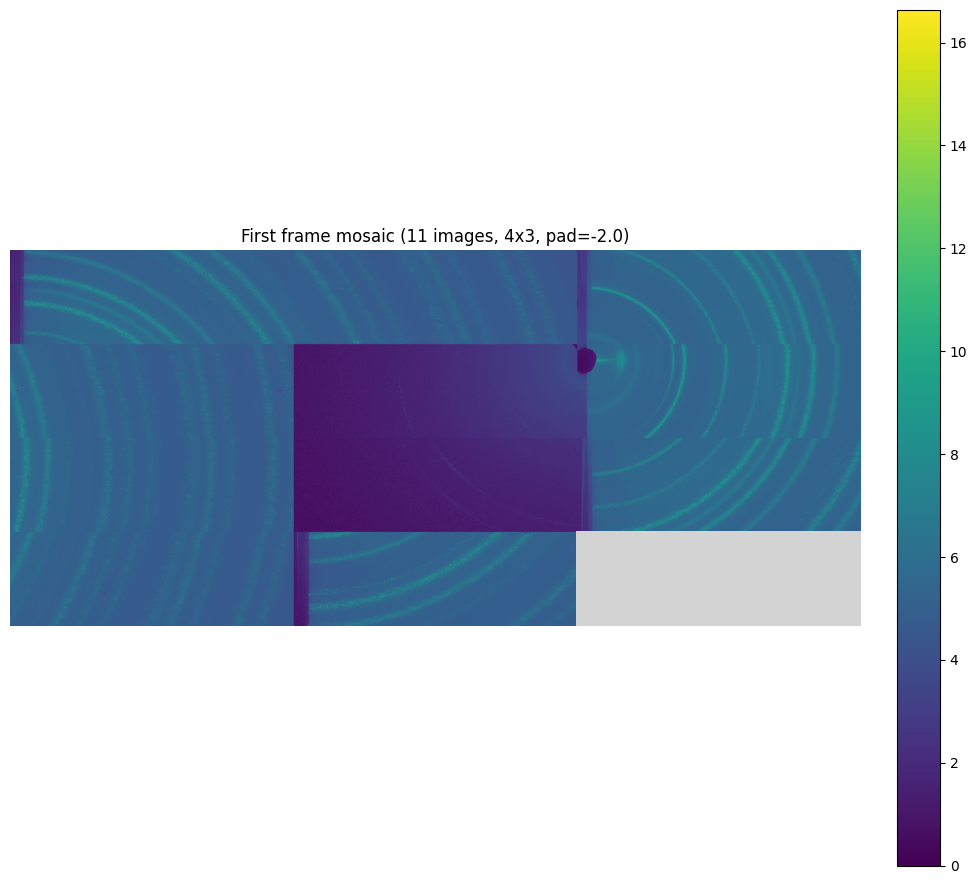

In [45]:
# Mosaic: 3 columns left-to-right, pad with -2, and display
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

cols = 3
pad_value = -2.0

n = len(images)
rows = int(ceil(n / cols))
H, W = images[0].shape

total = rows * cols
if total > n:
    pad_count = total - n
    images_padded = images + [np.full((H, W), pad_value, dtype=np.float32) for _ in range(pad_count)]
else:
    images_padded = images

row_blocks = []
for r in range(rows):
    row_imgs = images_padded[r*cols:(r+1)*cols]
    row_blocks.append(np.concatenate(row_imgs, axis=1))

grid = np.concatenate(row_blocks, axis=0)

# Mask padding so it doesn't affect color scaling
grid_ma = np.ma.masked_equal(grid, pad_value)
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='lightgray')

plt.figure(figsize=(cols*4, rows*4))
im = plt.imshow(np.log1p(grid_ma), cmap=cmap, origin='upper')
plt.title(f'First frame mosaic ({n} images, {rows}x{cols}, pad={pad_value})')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis('off')
plt.show()

In [40]:


def read_img_and_offset(nxs_path):
    with h5py.File(nxs_path, "r") as f:
        img = f["/entry/instrument/detector/data"][0].astype(np.float32)  # 取第0帧
        dist = list(f["/entry/instrument/detector/translation/distance"])
        tx = int(dist[1])  # x offset
        ty = int(dist[0])  # y offset
    return img, tx, ty

pad_value = np.nan  # 用 NaN 当 padding，更自然（后面 mask 也更简单）

H, W = images[0].shape

# offsets = [(tx, ty), ...]  和 images 一一对应
# 画布大小：右下角最大范围

max_x = max(tx + W for tx, ty in offsets)
max_y = max(ty + H for tx, ty in offsets)

# 注意：这里的 grid shape 用 (max_y, max_x) 对应 (row, col) = (y, x)
grid = np.full((max_y, max_x), pad_value, dtype=np.float32)

for img, (tx, ty) in zip(images, offsets):
    # img 是 (H, W)，贴到 grid[ty:ty+H, tx:tx+W]
    grid[ty:ty+H, tx:tx+W] = img

import matplotlib.pyplot as plt
import numpy as np

grid_ma = np.ma.masked_invalid(grid)  # mask NaN

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='lightgray')

plt.figure(figsize=(12, 6))
im = plt.imshow(np.log1p(grid_ma), cmap=cmap, origin='upper')  # log(1+I) 更稳
plt.title('First frame stitched mosaic (offset-based)')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis('off')
plt.show()

NameError: name 'offsets' is not defined

Using 1 file(s) from E:\P03_Yufeng\11020885\raw\ak_3_au_pet_dc_17p_align_00002\lmbd01:
 1: zhaonan_pvk_yscan_00001_00001_m01.nxs
Translations (P03 style) [trans_x, trans_y]: [(0, 1588)]


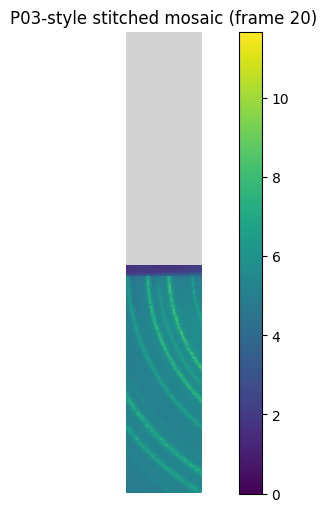

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# ----------------- 用户参数 -----------------
# nxs_file_path = r"E:\ExpData\Zhaonan\lmbd\lmbd\zhaonan_pvk_yscan_00001_00001_m09.nxs"
nxs_file_path = r"E:\P03_Yufeng\11020885\raw\ak_3_au_pet_dc_17p_align_00002\lmbd01\ak_3_au_pet_dc_17p_align_00002_00001.nxs"

dataset_path = "/entry/instrument/detector/data"
dist_path    = "/entry/instrument/detector/translation/distance"
mask_path    = "/entry/instrument/detector/pixel_mask"   # optional

frame_idx = 20  # 0-based

# P03 reader里写死的 module 尺寸（非常关键）
LMBDA_X = 516
LMBDA_Y = 1556

# ----------------- 收集 module 文件 -----------------
base_path = Path(nxs_file_path)
folder = Path(nxs_file_path).parent
base_name = base_path.name

# Detect suffix like "_m09.nxs" or "m09.nxs" and derive the exact prefix before the m-part
m_match = re.search(r"_m(\d+)\.nxs$", base_name, re.IGNORECASE)
sep = ""
prefix = None
if m_match:
    sep = "_"
    prefix = base_name[:m_match.start()]  # before "_mNN.nxs"
else:
    m2 = re.search(r"m(\d+)\.nxs$", base_name, re.IGNORECASE)
    if m2:
        sep = ""
        prefix = base_name[:m2.start()]   # before "mNN.nxs"

ordered_paths = []
if prefix is not None:
    # Build glob that preserves the exact prefix and matches m*.nxs
    glob_pat = f"{prefix}{sep}m*.nxs"
    series = []
    for p in folder.glob(glob_pat):
        mm = re.search(r"m(\d+)\.nxs$", p.name, re.IGNORECASE)
        if mm:
            series.append((int(mm.group(1)), p))
    if series:
        series.sort(key=lambda x: x[0])
        ordered_paths = [p for _, p in series]

# Fallback: if no series detected/matched, use the single file (if it's .nxs)
if not ordered_paths and base_path.suffix.lower() == ".nxs":
    ordered_paths = [base_path]

if not ordered_paths:
    raise FileNotFoundError(f"No m-series or single .nxs found for {base_path}")

print(f"Using {len(ordered_paths)} file(s) from {folder}:")
for i, p in enumerate(ordered_paths, 1):
    print(f"{i:2d}: {p.name}")

# ----------------- 读取每个 module 的图像 + translation -----------------
modules = []  # list of dicts: {img, trans_x, trans_y, mask}

for p in ordered_paths:
    with h5py.File(p, "r") as f:
        dset = f[dataset_path]

        # 兼容 (frames, H, W) / (H, W)
        if dset.ndim == 3:
            img = dset[frame_idx].astype(np.float32)
        elif dset.ndim == 2:
            img = dset[()].astype(np.float32)
        else:
            raise ValueError(f"Unexpected data ndim {dset.ndim} in {p.name}")

        # --- 关键：按 P03 reader 的方式 reverse (x,y) ---
        # P03 reader: trans_x = dist[1], trans_y = dist[0]
        dist = list(f[dist_path])
        trans_x = int(dist[1])
        trans_y = int(dist[0])

        # mask optional
        msk = f[mask_path][()] if mask_path in f else None

    # --- 关键：按 P03 reader 的方式，module image 期望尺寸是 (LMBDA_X, LMBDA_Y)
    # 但很多文件里读出来通常是 (LMBDA_Y, LMBDA_X)（即 y,x）
    # P03 reader 是直接把 dataset[md] 塞到 canvas[x:x+516, y:y+1556] 里，
    # 所以这里我们要把 img 转成 (x,y) 排布：img_xy.shape == (516,1556)
    if img.shape == (LMBDA_Y, LMBDA_X):
        img_xy = img.T  # (1556,516) -> (516,1556)
        msk_xy = msk.T if msk is not None and msk.shape == img.shape else msk
    elif img.shape == (LMBDA_X, LMBDA_Y):
        img_xy = img
        msk_xy = msk
    else:
        raise ValueError(
            f"{p.name}: unexpected module shape {img.shape}. "
            f"Expected {(LMBDA_Y, LMBDA_X)} or {(LMBDA_X, LMBDA_Y)}."
        )

    modules.append(
        dict(path=p, img=img_xy, trans_x=trans_x, trans_y=trans_y, mask=msk_xy)
    )

print("Translations (P03 style) [trans_x, trans_y]:",
      [(m["trans_x"], m["trans_y"]) for m in modules])

# ----------------- 处理可能的负 translation：整体平移到非负坐标 -----------------
min_tx = min(m["trans_x"] for m in modules)
min_ty = min(m["trans_y"] for m in modules)

shift_x = -min_tx if min_tx < 0 else 0
shift_y = -min_ty if min_ty < 0 else 0

for m in modules:
    m["sx"] = m["trans_x"] + shift_x
    m["sy"] = m["trans_y"] + shift_y

# ----------------- 按 P03 reader 推画布大小：pos = module_size + trans -----------------
# P03 reader: pos_x = LMBDA_X + trans_x, pos_y = LMBDA_Y + trans_y
size_x = 0
size_y = 0
for m in modules:
    pos_x = LMBDA_X + m["sx"]
    pos_y = LMBDA_Y + m["sy"]
    size_x = int(pos_x) if pos_x > size_x else int(size_x)
    size_y = int(pos_y) if pos_y > size_y else int(size_y)

# ----------------- 拼接（x-first：shape=(size_x, size_y)） -----------------
grid = np.full((size_x, size_y), np.nan, dtype=np.float32)

grid_mask = None
if any(m["mask"] is not None for m in modules):
    grid_mask = np.zeros((size_x, size_y), dtype=np.uint8)

for m in modules:
    x0, y0 = int(m["sx"]), int(m["sy"])
    grid[x0:x0+LMBDA_X, y0:y0+LMBDA_Y] = m["img"]

    if grid_mask is not None and m["mask"] is not None:
        # 常见约定：mask != 0 为坏点
        grid_mask[x0:x0+LMBDA_X, y0:y0+LMBDA_Y] = (m["mask"] != 0).astype(np.uint8)

# if grid_mask is not None:
#     grid = grid.copy()
#     grid[grid_mask != 0] = np.nan

# ----------------- 显示 -----------------
# grid 是 (x,y)。imshow 通常按 (row,col) = (y,x) 理解更直观。
# 所以这里转置一下显示，让你看到的方向跟常见 GISAXS 图像一致。
grid_show = grid.T  # (size_y, size_x)

grid_ma = np.ma.masked_invalid(grid_show)

cmap = plt.cm.viridis.copy()
cmap.set_bad(color="lightgray")

plt.figure(figsize=(12, 6))
im = plt.imshow(np.log1p(grid_ma), cmap=cmap, origin="upper")
plt.title(f"P03-style stitched mosaic (frame {frame_idx})")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()


In [43]:
print("raw dist example:", dist)

raw dist example: [1583.0, 2626.0, 0.0]
